In [1]:
import tqdm as tqdm
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
from torch.nn.functional import relu
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from skimage import io
import torch
from skimage import color
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.init as init
from PIL import Image, ImageOps
import pickle
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from copy import deepcopy

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('y')
else:
    device = torch.device('cpu')
    print('n')


y


In [3]:
sample_train_data = pd.read_csv( '../data/train_sample_pattern.csv')
sample_val_data =  pd.read_csv( '../data/val_sample_pattern.csv')
sample_test_data =  pd.read_csv( '../data/test_sample_pattern.csv')

In [4]:
full_train_data = pd.read_csv( '../data/classification_train.csv')
full_val_data =  pd.read_csv( '../data/classification_val.csv')
full_test_data =  pd.read_csv( '../data/classification_test.csv')

In [5]:
class FashionDataset(Dataset):
    def __init__(self, data_frame, img_dir, label, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = data_frame
        self.img_dir = img_dir
        self.clothing_type = data_frame['clothing_type']
        self.label = data_frame[label]

        self.transform = transform            

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir,
                                self.data_frame.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.label[idx]
        clothing_type = self.clothing_type[idx] 
        
        #Resize image and label to 572x572
        image = image.resize((572, 572))

        #Normalize the image
        image = np.asarray(image)
        min_image = np.min(image)
        max_image = np.max(image)
        image = (image - min_image)/(max_image - min_image + 1e-4)

        #Convert to tensors
        image = torch.tensor(np.array(image)).float().permute(2, 0, 1)
        label = torch.tensor(label).long()
        clothing_type = torch.tensor(clothing_type).long()
        sample = {'x': image, 'y': label, 'c': clothing_type}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.resnet18 = models.resnet18(weights=None) 
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_ftrs, 8)

    def forward(self, x):
        x = self.resnet18(x)
        return x

In [7]:
def train_model(model, dataloader, optimizer,  loss_fn, num_epochs = 10, verbose = False):
    f1_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    best_loss = np.inf
    best_f1 = 0
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            all_preds = []
            all_labels = []
            if p == 'train':
                model.train()
            else:
                model.eval()
            for data in dataloader[p]:
                optimizer.zero_grad()            
                image = data['x'].to(device)
                label = data['y'].to(device)
                output = model(image)
                loss = loss_fn(output, label)
                _, preds = torch.max(output, dim = 1)
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds ==label).item()
                running_loss += loss.item()*num_imgs
                running_total += num_imgs
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(label.cpu().numpy())
                if p== 'train':
                    loss.backward()
                    optimizer.step()
            epoch_acc = float(running_correct/running_total)
            epoch_loss = float(running_loss/running_total)
            epoch_f1 = f1_score(all_labels, all_preds, average='macro')
            if verbose or (i%10 == 0):
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f} F1 {:.4f}'.format(p, epoch_loss, epoch_acc, epoch_f1))

            f1_dict[p].append(epoch_f1)
            loss_dict[p].append(epoch_loss)
            if p == 'validate':
                if epoch_f1 > best_f1:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_f1 = epoch_f1
                    best_model_wts = deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best model val acc: {:4f} Best model val F1: {:4f}'.format(best_acc, best_f1))
    
    model.load_state_dict(best_model_wts)
    
    return model, f1_dict, loss_dict


### Baseline Pattern Classification Model

In [8]:
bs = 16

resnet_dataset = {'train': FashionDataset(full_train_data,'/vast/amr10211/cv_data/masked_images', 'pattern'), 
                  'validate': FashionDataset(full_val_data,'/vast/amr10211/cv_data/masked_images', 'pattern'), 
                  'test': FashionDataset(full_test_data, '/vast/amr10211/cv_data/masked_images', 'pattern')}

resnet_dataloader = {x: DataLoader(resnet_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate', 'test']}

In [9]:
resnet_model_pattern = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model_pattern.parameters(), lr=0.001)

bs = 16

resnet_model_pattern, resnet_f1_dict, resnet_loss_dict = train_model(resnet_model_pattern, 
                                                                      resnet_dataloader, 
                                                                      optimizer, 
                                                                      loss_fn=criterion, 
                                                                      num_epochs=10, 
                                                                      verbose=True)

Epoch: 0/9
----------
Phase:train, epoch loss: 1.0304 Acc: 0.6896 F1 0.1519
Phase:validate, epoch loss: 0.9832 Acc: 0.6894 F1 0.1601
Epoch: 1/9
----------
Phase:train, epoch loss: 0.9662 Acc: 0.7074 F1 0.1703
Phase:validate, epoch loss: 1.1615 Acc: 0.6399 F1 0.1292
Epoch: 2/9
----------
Phase:train, epoch loss: 0.9228 Acc: 0.7181 F1 0.1836
Phase:validate, epoch loss: 1.7282 Acc: 0.4534 F1 0.1450
Epoch: 3/9
----------
Phase:train, epoch loss: 0.8805 Acc: 0.7293 F1 0.1915
Phase:validate, epoch loss: 1.2087 Acc: 0.7175 F1 0.1618
Epoch: 4/9
----------
Phase:train, epoch loss: 0.8443 Acc: 0.7394 F1 0.2184
Phase:validate, epoch loss: 1.1415 Acc: 0.7089 F1 0.1742
Epoch: 5/9
----------
Phase:train, epoch loss: 0.8174 Acc: 0.7472 F1 0.2500
Phase:validate, epoch loss: 0.7968 Acc: 0.7531 F1 0.2572
Epoch: 6/9
----------
Phase:train, epoch loss: 0.7941 Acc: 0.7587 F1 0.2824
Phase:validate, epoch loss: 0.8500 Acc: 0.7422 F1 0.2880
Epoch: 7/9
----------
Phase:train, epoch loss: 0.7646 Acc: 0.7661 F1 

In [10]:
torch.save(resnet_model_pattern, 'pattern_classification_model_baseline.pth')

In [11]:
with open('pattern_classification_model_loss_dict_baseline.pkl', 'wb') as f:
    pickle.dump(resnet_loss_dict, f)

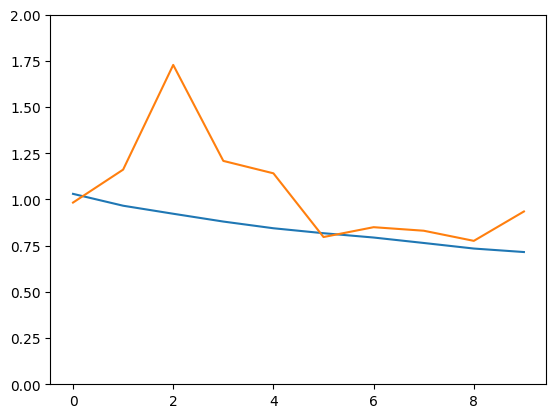

In [12]:
plt.plot(np.arange(0,10), resnet_loss_dict['train'])
plt.plot(np.arange(0,10), resnet_loss_dict['validate'])
plt.ylim(0,2);

In [13]:
correct = 0
total = 0
resnet_model_pattern.eval()
for data in resnet_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = resnet_model_pattern(image)
    pred = torch.argmax(output, axis=1)
    total += label.size(0)
    correct += (pred == label).sum()

test_acc = float(100 * correct / total)
print(test_acc)

76.69076538085938


In [14]:
resnet_model_pattern.eval()
y_true = []
y_pred = []

for data in resnet_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = resnet_model_pattern(image)
    pred = torch.argmax(output, axis=1)
    y_true.extend(label.cpu().numpy())
    y_pred.extend(pred.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Macro F1 score
macro_f1 = f1_score(y_true, y_pred, average='macro')

# One-vs-all AUC
# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

# Calculate one-vs-all AUC for each class
auc_scores = []
for i in range(n_classes):
    auc = roc_auc_score(y_true_bin[:, i], y_pred == i)
    auc_scores.append(auc)

# Average AUC scores across all classes
one_vs_all_auc = np.mean(auc_scores)

print("Macro F1 score:", macro_f1)
print("One-vs-all AUC:", one_vs_all_auc)

Macro F1 score: 0.32885988044374775
One-vs-all AUC: 0.6379203247774858


### Hyperparameter Tuning

In [15]:
batch_sizes = [8, 16]
learning_rates = [0.00001, 0.0001, 0.001]

resnet_dataset = {'train': FashionDataset(sample_train_data,'/vast/amr10211/cv_data/masked_images', 'pattern'), 
                  'validate': FashionDataset(sample_val_data,'/vast/amr10211/cv_data/masked_images', 'pattern'), 
                  'test': FashionDataset(sample_test_data, '/vast/amr10211/cv_data/masked_images', 'pattern')}

f1_dicts = []
loss_dicts = []
val_auc = []
train_auc = []
val_f1 = []
train_f1 = []

for batch_size in batch_sizes:
    sample_dataloader = {x: DataLoader(resnet_dataset[x], batch_size=batch_size,
                        shuffle=True, num_workers=0) for x in ['train', 'validate']}
    
    lr_f1_dict = []
    lr_loss_dict = []
    lr_val_auc = []
    lr_train_auc = []
    lr_val_f1 = []
    lr_train_f1 = []
    
    for learning_rate in learning_rates:

        print('-'*50)
        print(f'learning rate={learning_rate} and batch_size={batch_size}')
        print('-'*50)

        tune_model = ResNet18().to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(tune_model.parameters(), lr=learning_rate)

        tune_model_out, tune_f1_dict, tune_loss_dict = train_model(tune_model, sample_dataloader, optimizer, loss_fn, num_epochs=10, verbose = True)
        
        lr_f1_dict.append(tune_f1_dict)
        lr_loss_dict.append(tune_loss_dict)
        
        # AUC for train dataset
        tune_model_out.eval()
        train_predictions = []
        train_targets = []
        for data in sample_dataloader['train']:
            image = data['x'].to(device)
            label = data['y'].to(device)
            logits = tune_model_out(image)
            train_predictions.extend(torch.softmax(logits, dim=1).cpu().detach().numpy())
            train_targets.extend(label.cpu().detach().numpy())

        train_auc_score = roc_auc_score(np.array(train_targets), np.array(train_predictions), average='macro', multi_class='ovr')
        train_f1_score = f1_score(np.array(train_targets), np.argmax(np.array(train_predictions), axis=1), average='macro')
        print(f'Train AUC for lr={learning_rate} and batch_size={batch_size}:\n{train_auc_score:.2f}')
        print(f'Train F1 Score for lr={learning_rate} and batch_size={batch_size}:\n{train_f1_score:.2f}')
        lr_train_auc.append(train_auc_score)
        lr_train_f1.append(train_f1_score)
        

        # AUC for val dataset
        tune_model_out.eval()
        val_predictions = []
        val_targets = []
        for data in sample_dataloader['validate']:
            image = data['x'].to(device)
            label = data['y'].to(device)
            logits = tune_model_out(image)

            val_predictions.extend(torch.softmax(logits, dim=1).cpu().detach().numpy())
            val_targets.extend(label.cpu().detach().numpy())

        val_auc_score = roc_auc_score(np.array(val_targets), np.array(val_predictions), average='macro', multi_class='ovr')
        val_f1_score = f1_score(np.array(val_targets), np.argmax(np.array(val_predictions), axis=1), average='macro')
        print(f'Val AUC for lr={learning_rate} and batch_size={batch_size}:\n{val_auc_score:.2f}')
        print(f'Val F1 Score for lr={learning_rate} and batch_size={batch_size}:\n{val_f1_score:.2f}')
        lr_val_auc.append(val_auc_score)
        lr_val_f1.append(val_f1_score)

    f1_dicts.append(lr_f1_dict)
    loss_dicts.append(lr_loss_dict)
    val_auc.append(lr_val_auc)
    train_auc.append(lr_train_auc)
    val_f1.append(lr_val_f1)
    train_f1.append(lr_train_f1)

with open('hyperparameter_sample_pattern.pkl', 'wb') as f:
    pickle.dump((f1_dicts, loss_dicts, val_auc, train_auc, val_f1, train_f1), f)

--------------------------------------------------
learning rate=1e-05 and batch_size=8
--------------------------------------------------
Epoch: 0/9
----------
Phase:train, epoch loss: 1.3787 Acc: 0.6653 F1 0.1025
Phase:validate, epoch loss: 1.2690 Acc: 0.6618 F1 0.0996
Epoch: 1/9
----------
Phase:train, epoch loss: 1.1294 Acc: 0.6734 F1 0.1130
Phase:validate, epoch loss: 1.1163 Acc: 0.6765 F1 0.1197
Epoch: 2/9
----------
Phase:train, epoch loss: 1.0545 Acc: 0.6895 F1 0.1338
Phase:validate, epoch loss: 1.0725 Acc: 0.6765 F1 0.1189
Epoch: 3/9
----------
Phase:train, epoch loss: 1.0159 Acc: 0.6915 F1 0.1419
Phase:validate, epoch loss: 1.0255 Acc: 0.7059 F1 0.1483
Epoch: 4/9
----------
Phase:train, epoch loss: 0.9737 Acc: 0.6976 F1 0.1468
Phase:validate, epoch loss: 1.0341 Acc: 0.6912 F1 0.1423
Epoch: 5/9
----------
Phase:train, epoch loss: 0.9596 Acc: 0.6976 F1 0.1482
Phase:validate, epoch loss: 0.9968 Acc: 0.7059 F1 0.1468
Epoch: 6/9
----------
Phase:train, epoch loss: 0.9185 Acc: 0.71

In [16]:
with open('hyperparameter_sample_pattern.pkl', 'rb') as f:
    f1_dicts, loss_dicts, val_auc, train_auc, val_f1, train_f1 = pickle.load(f)

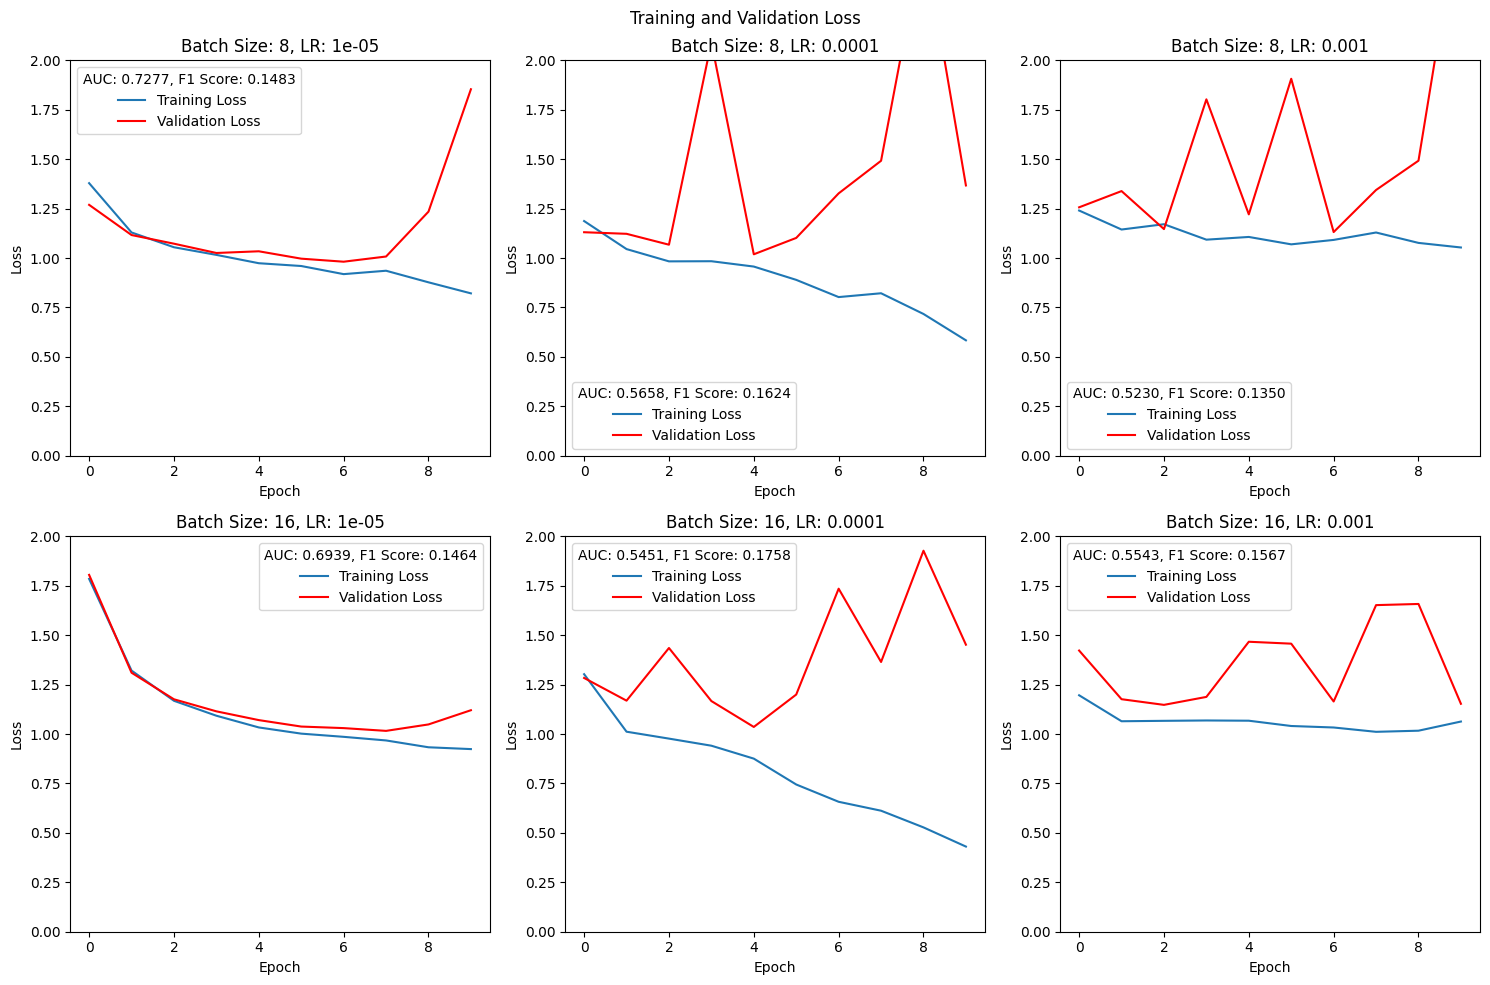

In [17]:
batch_sizes = [8, 16]
learning_rates = [0.00001, 0.0001, 0.001] 

fig, axs = plt.subplots(len(batch_sizes), len(learning_rates), figsize=(15, 10))
plt.suptitle('Training and Validation Loss')

for i, batch_size in enumerate(batch_sizes):
    for j, learning_rate in enumerate(learning_rates):
        axs[i,j].plot(loss_dicts[i][j]['train'], label='Training Loss')
        axs[i,j].plot(loss_dicts[i][j]['validate'], label='Validation Loss', color='red')
        axs[i,j].set_title(f'Batch Size: {batch_size}, LR: {learning_rate}')
        axs[i,j].set_xlabel('Epoch')
        axs[i,j].set_ylabel('Loss')
        axs[i,j].set_ylim(0,2)
        axs[i, j].legend(title=f'AUC: {val_auc[i][j]:.4f}, F1 Score: {val_f1[i][j]:.4f}')

plt.tight_layout()
plt.savefig('hyperparameter_tuning_loss_pattern.png')
plt.show()

### Hyperparameter Tuned Pattern Classification Model

In [11]:
bs = 16
resnet_dataset = {'train': FashionDataset(full_train_data,'/vast/amr10211/cv_data/masked_images', 'pattern'), 
                  'validate': FashionDataset(full_val_data,'/vast/amr10211/cv_data/masked_images', 'pattern'), 
                  'test': FashionDataset(full_test_data, '/vast/amr10211/cv_data/masked_images', 'pattern')}

resnet_dataloader = {x: DataLoader(resnet_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate', 'test']}

In [14]:
resnet_model_pattern = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model_pattern.parameters(), lr=0.0001)

resnet_model_pattern, resnet_f1_dict, resnet_loss_dict = train_model(resnet_model_pattern, 
                                                                      resnet_dataloader, 
                                                                      optimizer, 
                                                                      loss_fn=criterion, 
                                                                      num_epochs=10, 
                                                                      verbose=True)

Epoch: 0/9
----------
Phase:train, epoch loss: 0.9512 Acc: 0.7105 F1 0.1686
Phase:validate, epoch loss: 0.9812 Acc: 0.7209 F1 0.2002
Epoch: 1/9
----------
Phase:train, epoch loss: 0.8419 Acc: 0.7446 F1 0.2393
Phase:validate, epoch loss: 0.8992 Acc: 0.7550 F1 0.2829
Epoch: 2/9
----------
Phase:train, epoch loss: 0.7786 Acc: 0.7657 F1 0.3059
Phase:validate, epoch loss: 0.7464 Acc: 0.7711 F1 0.3202
Epoch: 3/9
----------
Phase:train, epoch loss: 0.7388 Acc: 0.7759 F1 0.3367
Phase:validate, epoch loss: 0.8188 Acc: 0.7595 F1 0.3556
Epoch: 4/9
----------
Phase:train, epoch loss: 0.7085 Acc: 0.7846 F1 0.3716
Phase:validate, epoch loss: 0.7585 Acc: 0.7714 F1 0.3359
Epoch: 5/9
----------
Phase:train, epoch loss: 0.6888 Acc: 0.7894 F1 0.3827
Phase:validate, epoch loss: 0.7497 Acc: 0.7849 F1 0.3546
Epoch: 6/9
----------
Phase:train, epoch loss: 0.6608 Acc: 0.7974 F1 0.4109
Phase:validate, epoch loss: 0.7673 Acc: 0.7587 F1 0.3496
Epoch: 7/9
----------
Phase:train, epoch loss: 0.6387 Acc: 0.8013 F1 

In [15]:
torch.save(resnet_model_pattern, 'pattern_classification_model.pth')

In [16]:
with open('pattern_classification_model_loss_dict.pkl', 'wb') as f:
    pickle.dump(resnet_loss_dict, f)

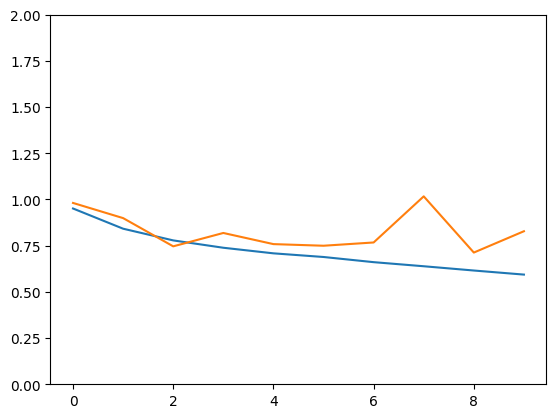

In [17]:
plt.plot(np.arange(0,10), resnet_loss_dict['train'])
plt.plot(np.arange(0,10), resnet_loss_dict['validate'])
plt.ylim(0,2);

In [18]:
correct = 0
total = 0
resnet_model_pattern.eval()
for data in resnet_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = resnet_model_pattern(image)
    pred = torch.argmax(output, axis=1)
    total += label.size(0)
    correct += (pred == label).sum()

test_acc = float(100 * correct / total)
print(test_acc)

74.60655212402344


In [19]:
resnet_model_pattern.eval()
y_true = []
y_pred = []

for data in resnet_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = resnet_model_pattern(image)
    pred = torch.argmax(output, axis=1)
    y_true.extend(label.cpu().numpy())
    y_pred.extend(pred.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Macro F1 score
macro_f1 = f1_score(y_true, y_pred, average='macro')

# One-vs-all AUC
# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

# Calculate one-vs-all AUC for each class
auc_scores = []
for i in range(n_classes):
    auc = roc_auc_score(y_true_bin[:, i], y_pred == i)
    auc_scores.append(auc)

# Average AUC scores across all classes
one_vs_all_auc = np.mean(auc_scores)

print("Macro F1 score:", macro_f1)
print("One-vs-all AUC:", one_vs_all_auc)


Macro F1 score: 0.42613294457803363
One-vs-all AUC: 0.6994625934686447


### 15 Additional Epochs Tuned Pattern Classification Model

In [8]:
bs = 16
resnet_dataset = {'train': FashionDataset(full_train_data,'/vast/amr10211/cv_data/masked_images', 'pattern'), 
                  'validate': FashionDataset(full_val_data,'/vast/amr10211/cv_data/masked_images', 'pattern'), 
                  'test': FashionDataset(full_test_data, '/vast/amr10211/cv_data/masked_images', 'pattern')}

resnet_dataloader = {x: DataLoader(resnet_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate', 'test']}

In [9]:
resnet_model_pattern = torch.load('pattern_classification_model.pth').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model_pattern.parameters(), lr=0.0001)

resnet_model_pattern, resnet_f1_dict, resnet_loss_dict = train_model(resnet_model_pattern, 
                                                                      resnet_dataloader, 
                                                                      optimizer, 
                                                                      loss_fn=criterion, 
                                                                      num_epochs=15, 
                                                                      verbose=True)

Epoch: 0/14
----------
Phase:train, epoch loss: 0.5616 Acc: 0.8215 F1 0.5095
Phase:validate, epoch loss: 0.7462 Acc: 0.7711 F1 0.4520
Epoch: 1/14
----------
Phase:train, epoch loss: 0.5297 Acc: 0.8297 F1 0.5281
Phase:validate, epoch loss: 0.8451 Acc: 0.7666 F1 0.3977
Epoch: 2/14
----------
Phase:train, epoch loss: 0.4913 Acc: 0.8410 F1 0.5646
Phase:validate, epoch loss: 0.7074 Acc: 0.7842 F1 0.5274
Epoch: 3/14
----------
Phase:train, epoch loss: 0.4398 Acc: 0.8577 F1 0.6099
Phase:validate, epoch loss: 0.7144 Acc: 0.7936 F1 0.4386
Epoch: 4/14
----------
Phase:train, epoch loss: 0.3855 Acc: 0.8736 F1 0.6550
Phase:validate, epoch loss: 1.0275 Acc: 0.7666 F1 0.4193
Epoch: 5/14
----------
Phase:train, epoch loss: 0.3144 Acc: 0.8964 F1 0.7093
Phase:validate, epoch loss: 1.0857 Acc: 0.7010 F1 0.4160
Epoch: 6/14
----------
Phase:train, epoch loss: 0.2513 Acc: 0.9165 F1 0.7712
Phase:validate, epoch loss: 1.0482 Acc: 0.7115 F1 0.4040
Epoch: 7/14
----------
Phase:train, epoch loss: 0.2003 Acc: 0.

In [10]:
torch.save(resnet_model_pattern, 'pattern_classification_model_25_epochs.pth')

In [11]:
with open('pattern_classification_model_loss_dict_25_epochs.pkl', 'wb') as f:
    pickle.dump(resnet_loss_dict, f)

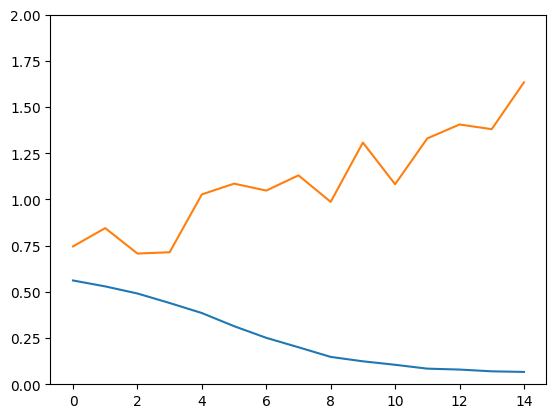

In [13]:
plt.plot(np.arange(0,15), resnet_loss_dict['train'])
plt.plot(np.arange(0,15), resnet_loss_dict['validate'])
plt.ylim(0,2);

In [14]:
correct = 0
total = 0
resnet_model_pattern.eval()
for data in resnet_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = resnet_model_pattern(image)
    pred = torch.argmax(output, axis=1)
    total += label.size(0)
    correct += (pred == label).sum()

test_acc = float(100 * correct / total)
print(test_acc)

78.05189514160156


In [15]:
resnet_model_pattern.eval()
y_true = []
y_pred = []

for data in resnet_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = resnet_model_pattern(image)
    pred = torch.argmax(output, axis=1)
    y_true.extend(label.cpu().numpy())
    y_pred.extend(pred.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Macro F1 score
macro_f1 = f1_score(y_true, y_pred, average='macro')

# One-vs-all AUC
# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

# Calculate one-vs-all AUC for each class
auc_scores = []
for i in range(n_classes):
    auc = roc_auc_score(y_true_bin[:, i], y_pred == i)
    auc_scores.append(auc)

# Average AUC scores across all classes
one_vs_all_auc = np.mean(auc_scores)

print("Macro F1 score:", macro_f1)
print("One-vs-all AUC:", one_vs_all_auc)

Macro F1 score: 0.522222509737717
One-vs-all AUC: 0.7255656464373814
